In [1]:
# For Google Colab only
# !pip uninstall -y numpy
# !pip install numpy==1.24.4

In [2]:
# For Google Colab only
# !pip install monai==1.2.0

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_path = '/content/drive/MyDrive/Trabajo/Entrevistas/20250611 Eden/challenge/public_data/'

In [1]:
# Importaciones principales de PyTorch y MONAI
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Importaciones de MONAI para imágenes médicas
from monai.networks.nets import UNet
from monai.losses import DiceCELoss
from monai.transforms import (
    Compose,
    LoadImageD,
    ScaleIntensityD,
    ResizeD,
    RandRotateD,
    RandFlipD,
    RandGaussianNoiseD,
)
from monai.utils import set_determinism

# Librerías estándar y de imagen
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings('ignore')

# Inicializa el GradScaler UNA VEZ, antes del bucle de entrenamiento
scaler = GradScaler()

In [8]:
IMG_PATH = '../public_data/512/images'
MSK_PATH = '../public_data/512/masks'

In [ ]:
# For Google Colab only
# # Rutas originales en Google Drive
# GDRIVE_IMG_PATH = base_path + 'image/'
# GDRIVE_MSK_PATH = base_path + 'mask/'

# # Definimos el tamaño objetivo aquí para usarlo en el pre-procesamiento
# TARGET_SIZE = (512, 512) # (width, height) para OpenCV

# # Rutas locales para los datos ya procesados y redimensionados
# LOCAL_IMG_PATH_FINAL = f'/content/dataset/images/'
# LOCAL_MSK_PATH_FINAL = f'/content/dataset/masks/'

# # Crear directorios locales
# os.makedirs(LOCAL_IMG_PATH_FINAL, exist_ok=True)
# os.makedirs(LOCAL_MSK_PATH_FINAL, exist_ok=True)

# print("Iniciando pre-procesamiento completo (Resize + CLAHE)...")

# # Inicializar CLAHE de OpenCV
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# try:
#     img_files = sorted([f for f in os.listdir(GDRIVE_IMG_PATH) if f.endswith('.png')])

#     # --- Procesar Imágenes ---
#     for file_name in tqdm(img_files, desc="Procesando Imágenes"):
#         img_path = os.path.join(GDRIVE_IMG_PATH, file_name)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if img is not None:
#             # 1. Redimensionar la imagen
#             img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
#             # 2. Aplicar CLAHE
#             img_clahe = clahe.apply(img_resized)
#             # 3. Guardar en el directorio local final
#             cv2.imwrite(os.path.join(LOCAL_IMG_PATH_FINAL, file_name), img_clahe)

#     # --- Procesar Máscaras ---
#     mask_files = sorted([f for f in os.listdir(GDRIVE_MSK_PATH) if f.endswith('.png')])
#     for file_name in tqdm(mask_files, desc="Procesando Máscaras"):
#         msk_path = os.path.join(GDRIVE_MSK_PATH, file_name)
#         msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE) # Cargar en escala de grises
#         if msk is not None:
#             # Redimensionar la máscara (usar interpolación nearest para mantener valores binarios)
#             msk_resized = cv2.resize(msk, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
#             # Guardar en el directorio local final
#             cv2.imwrite(os.path.join(LOCAL_MSK_PATH_FINAL, file_name), msk_resized)

#     print(f"\n¡Pre-procesamiento completado! Imágenes y máscaras procesadas y redimensionadas a {TARGET_SIZE}.")

# except FileNotFoundError:
#     print("\nNo se encontraron los directorios de Google Drive. Saltando el pre-procesamiento.")
#     print("Asegúrate de que las rutas de GDrive son correctas.")

# print(f"\nNuevas rutas del dataset:")
# print(f"Imágenes: {LOCAL_IMG_PATH_FINAL}")
# print(f"Máscaras: {LOCAL_MSK_PATH_FINAL}")

Iniciando pre-procesamiento completo (Resize + CLAHE)...


Procesando Máscaras: 100%|██████████| 704/704 [00:43<00:00, 16.24it/s]


¡Pre-procesamiento completado! Imágenes y máscaras procesadas y redimensionadas a (512, 512).

Nuevas rutas del dataset:
Imágenes: /content/dataset/images/
Máscaras: /content/dataset/masks/


In [ ]:
# For Google Colab only
# IMG_PATH = '/content/dataset/images/'
# MSK_PATH = '/content/dataset/masks/'

In [13]:
# Configuración del dispositivo y reproducibilidad
set_determinism(seed=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros de entrenamiento
TARGET_SIZE = (512, 512)
BATCH_SIZE = 32

# For google colab only
# NUM_WORKERS = 4
NUM_WORKERS = 0
NUM_EPOCHS = 500
LEARNING_RATE = 1e-4

Usando dispositivo: cpu


In [14]:
# --- TRANSFORMACIONES ---

# Pipeline de transformaciones para el conjunto de entrenamiento
train_transforms = Compose([
    # Carga la imagen y máscara desde la ruta (ya miden 512x512)
    LoadImageD(keys=["image", "mask"], image_only=True, ensure_channel_first=True),
    # Normaliza la intensidad de la imagen a [0, 1]
    ScaleIntensityD(keys=["image"]),
    # Normaliza la máscara a [0, 1]
    ScaleIntensityD(keys=["mask"], minv=0.0, maxv=1.0),
    # ResizeD(keys=["image", "mask"], spatial_size=TARGET_SIZE, mode=("bilinear", "nearest")),
    # Aumento de datos (se aplica sobre las imágenes ya redimensionadas)
    RandRotateD(keys=["image", "mask"], range_x=0.1, prob=0.3, mode=("bilinear", "nearest")),
    RandFlipD(keys=["image", "mask"], spatial_axis=1, prob=0.3),
    RandGaussianNoiseD(keys=["image"], prob=0.15, mean=0, std=0.1),
])

# Pipeline de transformaciones para el conjunto de validación
val_transforms = Compose([
    LoadImageD(keys=["image", "mask"], image_only=True, ensure_channel_first=True),
    ScaleIntensityD(keys=["image"]),
    ScaleIntensityD(keys=["mask"], minv=0.0, maxv=1.0),
    # ResizeD(keys=["image", "mask"], spatial_size=TARGET_SIZE, mode=("bilinear", "nearest")),
])

In [15]:
class LungSegmentationDataset(Dataset):
    """
    Dataset optimizado que delega la carga y transformación a MONAI.
    """
    def __init__(self, image_files, mask_files, img_dir, mask_dir, transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Crear un diccionario con las rutas de los archivos
        data_dict = {
            "image": os.path.join(self.img_dir, self.image_files[idx]),
            "mask": os.path.join(self.mask_dir, self.mask_files[idx])
        }

        # Dejar que las transformaciones de MONAI se encarguen de todo
        if self.transforms:
            data_dict = self.transforms(data_dict)

        # Binarizar la máscara después de las transformaciones para asegurar 0s y 1s
        data_dict["mask"] = (data_dict["mask"] > 0.5).float()

        return data_dict["image"], data_dict["mask"]

In [16]:
# Cargar lista de archivos desde los directorios LOCALES
try:
    img_files = sorted([f for f in os.listdir(IMG_PATH) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(MSK_PATH) if f.endswith('.png')])
    print(f"Encontradas {len(img_files)} imágenes y {len(mask_files)} máscaras en el disco local.")

    # Dividir dataset
    train_img_files, val_img_files, train_mask_files, val_mask_files = train_test_split(
        img_files, mask_files, test_size=0.3, random_state=42
    )

    print(f"Muestras de entrenamiento: {len(train_img_files)}")
    print(f"Muestras de validación: {len(val_img_files)}")

    # Crear datasets
    train_dataset = LungSegmentationDataset(
        image_files=train_img_files, mask_files=train_mask_files,
        img_dir=IMG_PATH, mask_dir=MSK_PATH, transforms=train_transforms
    )
    val_dataset = LungSegmentationDataset(
        image_files=val_img_files, mask_files=val_mask_files,
        img_dir=IMG_PATH, mask_dir=MSK_PATH, transforms=val_transforms
    )

    # Crear data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available()
    )

    print(f"Lotes de entrenamiento: {len(train_loader)}")
    print(f"Lotes de validación: {len(val_loader)}")

except FileNotFoundError:
    print("No se encontraron los directorios locales. Asegúrate de que la celda 3 se ejecutó correctamente.")

Encontradas 704 imágenes y 704 máscaras en el disco local.
Muestras de entrenamiento: 492
Muestras de validación: 212
Lotes de entrenamiento: 16
Lotes de validación: 7


In [17]:
def create_unet_model(
    spatial_dims=2, in_channels=1, out_channels=1,
    channels=(64, 128, 256, 512), strides=(2, 2, 2), num_res_units=2
):
    """Crea un modelo U-Net de MONAI."""
    model = UNet(
        spatial_dims=spatial_dims, in_channels=in_channels, out_channels=out_channels,
        channels=channels, strides=strides, num_res_units=num_res_units,
        norm='batch', dropout=0.2,
    )
    return model

# Crear el modelo y moverlo al dispositivo
model = create_unet_model().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"¡Modelo creado exitosamente!")
print(f"Número de parámetros entrenables: {count_parameters(model):,}")
print(f"El modelo está en el dispositivo: {next(model.parameters()).device}")

¡Modelo creado exitosamente!
Número de parámetros entrenables: 6,408,154
El modelo está en el dispositivo: cpu


In [19]:
# Función de pérdida combinada de MONAI
# loss_function = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
from monai.losses import TverskyLoss
loss_function = TverskyLoss(sigmoid=True, include_background=True, alpha=0.5, beta=0.5, reduction='mean')


# Optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Programador de tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Funciones para calcular métricas durante el bucle
def calculate_dice(pred, target, smooth=1e-6):
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    dice = (2.0 * intersection + smooth) / (pred_binary.sum() + target.sum() + smooth)
    return dice.item()

def calculate_iou(pred, target, smooth=1e-6):
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

print("¡Funciones de pérdida, métricas y optimizador configurados exitosamente!")

¡Funciones de pérdida, métricas y optimizador configurados exitosamente!


In [10]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_dice, total_iou = 0, 0, 0
    progress_bar = tqdm(loader, desc="Entrenamiento (AMP)")

    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # --- INICIO DE CAMBIOS PARA AMP ---
        # 1. Envuelve el pase hacia adelante con autocast
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)

        # 2. Escala la pérdida y realiza el pase hacia atrás
        scaler.scale(loss).backward()

        # 3. Actualiza los pesos
        scaler.step(optimizer)

        # 4. Actualiza la escala para la siguiente iteración
        scaler.update()
        # --- FIN DE CAMBIOS PARA AMP ---

        total_loss += loss.item()
        # El resto del cálculo de métricas no necesita estar en autocast
        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            dice = calculate_dice(probs, masks)
            iou = calculate_iou(probs, masks)
            total_dice += dice
            total_iou += iou

        progress_bar.set_postfix({'Pérdida': f'{loss.item():.4f}', 'Dice': f'{dice:.4f}', 'IoU': f'{iou:.4f}'})

    return total_loss / len(loader), total_dice / len(loader), total_iou / len(loader)

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_dice, total_iou = 0, 0, 0
    progress_bar = tqdm(loader, desc="Validación")

    with torch.no_grad():
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            dice = calculate_dice(probs, masks)
            iou = calculate_iou(probs, masks)
            total_dice += dice
            total_iou += iou

            progress_bar.set_postfix({'Pérdida': f'{loss.item():.4f}', 'Dice': f'{dice:.4f}', 'IoU': f'{iou:.4f}'})

    return total_loss / len(loader), total_dice / len(loader), total_iou / len(loader)
# def validate_epoch(model, loader, loss_fn, device):
#     print("\n--- INICIANDO VALIDACIÓN EN MODO DEBUG ---")
#     model.eval() # Mantenemos el modo de evaluación para replicar el error

#     with torch.no_grad():
#         # Solo revisaremos el primer lote para no llenar la pantalla
#         images, masks = next(iter(loader))
#         images, masks = images.to(device), masks.to(device)

#         # Pase hacia adelante
#         outputs = model(images)

#         # Aplicar sigmoide para obtener probabilidades
#         probs = torch.sigmoid(outputs)

#         print("\n--- Estadísticas de la Salida del Modelo (1er Lote) ---")
#         print(f"Salida cruda (outputs) - Mín: {outputs.min():.4f}, Máx: {outputs.max():.4f}, Media: {outputs.mean():.4f}")
#         print(f"Probabilidades (probs) - Mín: {probs.min():.4f}, Máx: {probs.max():.4f}, Media: {probs.mean():.4f}")

#         # Calcular Dice para este lote para confirmar que da cero
#         dice = calculate_dice(probs, masks)
#         print(f"\nDice calculado para este lote: {dice:.4f}")

#         # Visualizar la primera predicción del lote
#         fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#         img_np = images[0].cpu().numpy().squeeze()
#         msk_np = masks[0].cpu().numpy().squeeze()
#         prd_np = probs[0].cpu().numpy().squeeze()

#         axes[0].imshow(img_np, cmap='gray'); axes[0].set_title('Imagen de Validación')
#         axes[1].imshow(msk_np, cmap='gray'); axes[1].set_title('Máscara Verdadera')
#         axes[2].imshow(prd_np > 0.5, cmap='gray'); axes[2].set_title('Predicción del Modelo')
#         plt.suptitle("Inspección de la Predicción")
#         plt.show()

#     print("--- FIN DE VALIDACIÓN EN MODO DEBUG ---\n")

In [11]:
best_val_dice = 0
train_history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

# Parámetros de Early Stopping
EARLY_STOPPING_PATIENCE = 15 # Número de épocas sin mejora en la métrica de validación antes de detenerse
epochs_without_improvement = 0

print("Iniciando entrenamiento...")
# Ahora entrenaremos por un número máximo de épocas, pero nos detendremos antes si se cumple la paciencia del early stopping
print(f"Épocas máximas: {NUM_EPOCHS}, Tamaño de Lote: {BATCH_SIZE}, Dispositivo: {device}")
print(f"Paciencia de Early Stopping (basado en Dice de validación): {EARLY_STOPPING_PATIENCE} épocas")


for epoch in range(NUM_EPOCHS):
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_dice, train_iou = train_epoch(model, train_loader, optimizer, loss_function, device)
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, loss_function, device)
    scheduler.step(val_loss) # Puedes decidir si usar val_loss o val_dice para el scheduler

    train_history['train_loss'].append(train_loss)
    train_history['train_dice'].append(train_dice)
    train_history['train_iou'].append(train_iou)
    train_history['val_loss'].append(val_loss)
    train_history['val_dice'].append(val_dice)
    train_history['val_iou'].append(val_iou)

    print(f"Entren - Pérdida: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Valid  - Pérdida: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # --- Lógica de Early Stopping ---
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_unet_model.pth')
        print(f"¡Nuevo mejor modelo guardado! Dice de validación: {best_val_dice:.4f}")
        epochs_without_improvement = 0 # Reiniciar contador si hay mejora
    else:
        epochs_without_improvement += 1 # Incrementar contador si no hay mejora
        print(f"No hay mejora en Dice de validación. Épocas sin mejora: {epochs_without_improvement}/{EARLY_STOPPING_PATIENCE}")

    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\n¡Early stopping activado después de {EARLY_STOPPING_PATIENCE} épocas sin mejora!")
        break # Detener el bucle de entrenamiento
    # --- Fin Lógica de Early Stopping ---


print(f"\n¡Entrenamiento completado! Mejor Dice de validación: {best_val_dice:.4f}")

Iniciando entrenamiento...
Épocas máximas: 500, Tamaño de Lote: 32, Dispositivo: cuda
Paciencia de Early Stopping (basado en Dice de validación): 15 épocas

Época 1/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s, Pérdida=0.6537, Dice=0.3012, IoU=0.1773]


Entren - Pérdida: 0.5963, Dice: 0.5363, IoU: 0.3727
Valid  - Pérdida: 0.6593, Dice: 0.3162, IoU: 0.1880
¡Nuevo mejor modelo guardado! Dice de validación: 0.3162

Época 2/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, Pérdida=0.7115, Dice=0.0000, IoU=0.0000]


Entren - Pérdida: 0.5306, Dice: 0.7378, IoU: 0.5867
Valid  - Pérdida: 0.7198, Dice: 0.0000, IoU: 0.0000
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 3/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s, Pérdida=0.6809, Dice=0.0184, IoU=0.0093]


Entren - Pérdida: 0.5026, Dice: 0.8146, IoU: 0.6876
Valid  - Pérdida: 0.6906, Dice: 0.0130, IoU: 0.0066
No hay mejora en Dice de validación. Épocas sin mejora: 2/15

Época 4/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Pérdida=0.5746, Dice=0.6362, IoU=0.4665]


Entren - Pérdida: 0.4887, Dice: 0.8491, IoU: 0.7380
Valid  - Pérdida: 0.6023, Dice: 0.5678, IoU: 0.3984
¡Nuevo mejor modelo guardado! Dice de validación: 0.5678

Época 5/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, Pérdida=0.4582, Dice=0.8437, IoU=0.7296]


Entren - Pérdida: 0.4785, Dice: 0.8734, IoU: 0.7753
Valid  - Pérdida: 0.4741, Dice: 0.8468, IoU: 0.7344
¡Nuevo mejor modelo guardado! Dice de validación: 0.8468

Época 6/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Pérdida=0.4585, Dice=0.7489, IoU=0.5986]


Entren - Pérdida: 0.4729, Dice: 0.8860, IoU: 0.7955
Valid  - Pérdida: 0.4692, Dice: 0.7615, IoU: 0.6152
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 7/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s, Pérdida=0.4597, Dice=0.7538, IoU=0.6049]


Entren - Pérdida: 0.4665, Dice: 0.8973, IoU: 0.8139
Valid  - Pérdida: 0.4706, Dice: 0.7648, IoU: 0.6195
No hay mejora en Dice de validación. Épocas sin mejora: 2/15

Época 8/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it, Pérdida=0.4539, Dice=0.7929, IoU=0.6568]


Entren - Pérdida: 0.4620, Dice: 0.9059, IoU: 0.8281
Valid  - Pérdida: 0.4660, Dice: 0.7987, IoU: 0.6652
No hay mejora en Dice de validación. Épocas sin mejora: 3/15

Época 9/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s, Pérdida=0.4631, Dice=0.7363, IoU=0.5827]


Entren - Pérdida: 0.4564, Dice: 0.9134, IoU: 0.8406
Valid  - Pérdida: 0.4723, Dice: 0.7498, IoU: 0.6001
No hay mejora en Dice de validación. Épocas sin mejora: 4/15

Época 10/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.4565, Dice=0.7456, IoU=0.5943]


Entren - Pérdida: 0.4544, Dice: 0.9160, IoU: 0.8451
Valid  - Pérdida: 0.4659, Dice: 0.7592, IoU: 0.6122
No hay mejora en Dice de validación. Épocas sin mejora: 5/15

Época 11/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s, Pérdida=0.4430, Dice=0.8075, IoU=0.6772]


Entren - Pérdida: 0.4520, Dice: 0.9137, IoU: 0.8414
Valid  - Pérdida: 0.4553, Dice: 0.8149, IoU: 0.6880
No hay mejora en Dice de validación. Épocas sin mejora: 6/15

Época 12/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, Pérdida=0.4291, Dice=0.8447, IoU=0.7311]


Entren - Pérdida: 0.4485, Dice: 0.9233, IoU: 0.8575
Valid  - Pérdida: 0.4439, Dice: 0.8433, IoU: 0.7292
No hay mejora en Dice de validación. Épocas sin mejora: 7/15

Época 13/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it, Pérdida=0.4217, Dice=0.8492, IoU=0.7379]


Entren - Pérdida: 0.4463, Dice: 0.9257, IoU: 0.8618
Valid  - Pérdida: 0.4374, Dice: 0.8472, IoU: 0.7351
¡Nuevo mejor modelo guardado! Dice de validación: 0.8472

Época 14/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, Pérdida=0.4355, Dice=0.8141, IoU=0.6865]


Entren - Pérdida: 0.4437, Dice: 0.9257, IoU: 0.8619
Valid  - Pérdida: 0.4475, Dice: 0.8224, IoU: 0.6987
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 15/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, Pérdida=0.4224, Dice=0.8467, IoU=0.7342]


Entren - Pérdida: 0.4422, Dice: 0.9283, IoU: 0.8664
Valid  - Pérdida: 0.4376, Dice: 0.8446, IoU: 0.7313
No hay mejora en Dice de validación. Épocas sin mejora: 2/15

Época 16/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, Pérdida=0.4308, Dice=0.8143, IoU=0.6868]


Entren - Pérdida: 0.4372, Dice: 0.9322, IoU: 0.8732
Valid  - Pérdida: 0.4424, Dice: 0.8247, IoU: 0.7019
No hay mejora en Dice de validación. Épocas sin mejora: 3/15

Época 17/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.4120, Dice=0.8530, IoU=0.7437]


Entren - Pérdida: 0.4363, Dice: 0.9328, IoU: 0.8742
Valid  - Pérdida: 0.4276, Dice: 0.8526, IoU: 0.7433
¡Nuevo mejor modelo guardado! Dice de validación: 0.8526

Época 18/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:07<00:00,  1.05s/it, Pérdida=0.4304, Dice=0.8323, IoU=0.7127]


Entren - Pérdida: 0.4339, Dice: 0.9337, IoU: 0.8757
Valid  - Pérdida: 0.4428, Dice: 0.8404, IoU: 0.7250
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 19/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.4197, Dice=0.8115, IoU=0.6827]


Entren - Pérdida: 0.4326, Dice: 0.9325, IoU: 0.8737
Valid  - Pérdida: 0.4322, Dice: 0.8209, IoU: 0.6964
No hay mejora en Dice de validación. Épocas sin mejora: 2/15

Época 20/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s, Pérdida=0.4198, Dice=0.8302, IoU=0.7097]


Entren - Pérdida: 0.4312, Dice: 0.9333, IoU: 0.8750
Valid  - Pérdida: 0.4330, Dice: 0.8352, IoU: 0.7173
No hay mejora en Dice de validación. Épocas sin mejora: 3/15

Época 21/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, Pérdida=0.4081, Dice=0.8724, IoU=0.7737]


Entren - Pérdida: 0.4283, Dice: 0.9349, IoU: 0.8779
Valid  - Pérdida: 0.4241, Dice: 0.8686, IoU: 0.7679
¡Nuevo mejor modelo guardado! Dice de validación: 0.8686

Época 22/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, Pérdida=0.4091, Dice=0.8530, IoU=0.7437]


Entren - Pérdida: 0.4263, Dice: 0.9337, IoU: 0.8758
Valid  - Pérdida: 0.4229, Dice: 0.8559, IoU: 0.7483
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 23/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it, Pérdida=0.4060, Dice=0.8702, IoU=0.7703]


Entren - Pérdida: 0.4233, Dice: 0.9375, IoU: 0.8825
Valid  - Pérdida: 0.4216, Dice: 0.8699, IoU: 0.7699
¡Nuevo mejor modelo guardado! Dice de validación: 0.8699

Época 24/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.4040, Dice=0.8608, IoU=0.7556]


Entren - Pérdida: 0.4195, Dice: 0.9408, IoU: 0.8883
Valid  - Pérdida: 0.4200, Dice: 0.8582, IoU: 0.7517
No hay mejora en Dice de validación. Épocas sin mejora: 1/15

Época 25/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, Pérdida=0.4120, Dice=0.8357, IoU=0.7177]


Entren - Pérdida: 0.4205, Dice: 0.9388, IoU: 0.8848
Valid  - Pérdida: 0.4250, Dice: 0.8400, IoU: 0.7242
No hay mejora en Dice de validación. Épocas sin mejora: 2/15

Época 26/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Pérdida=0.3984, Dice=0.8712, IoU=0.7719]


Entren - Pérdida: 0.4167, Dice: 0.9424, IoU: 0.8912
Valid  - Pérdida: 0.4140, Dice: 0.8692, IoU: 0.7688
No hay mejora en Dice de validación. Épocas sin mejora: 3/15

Época 27/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.4000, Dice=0.8512, IoU=0.7409]


Entren - Pérdida: 0.4158, Dice: 0.9416, IoU: 0.8897
Valid  - Pérdida: 0.4147, Dice: 0.8517, IoU: 0.7418
No hay mejora en Dice de validación. Épocas sin mejora: 4/15

Época 28/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it, Pérdida=0.4042, Dice=0.8381, IoU=0.7212]


Entren - Pérdida: 0.4128, Dice: 0.9434, IoU: 0.8929
Valid  - Pérdida: 0.4172, Dice: 0.8421, IoU: 0.7275
No hay mejora en Dice de validación. Épocas sin mejora: 5/15

Época 29/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Pérdida=0.3957, Dice=0.8565, IoU=0.7491]


Entren - Pérdida: 0.4109, Dice: 0.9437, IoU: 0.8935
Valid  - Pérdida: 0.4094, Dice: 0.8611, IoU: 0.7562
No hay mejora en Dice de validación. Épocas sin mejora: 6/15

Época 30/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s, Pérdida=0.3977, Dice=0.8487, IoU=0.7371]


Entren - Pérdida: 0.4097, Dice: 0.9437, IoU: 0.8935
Valid  - Pérdida: 0.4121, Dice: 0.8508, IoU: 0.7404
No hay mejora en Dice de validación. Épocas sin mejora: 7/15

Época 31/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, Pérdida=0.3960, Dice=0.8584, IoU=0.7519]


Entren - Pérdida: 0.4064, Dice: 0.9460, IoU: 0.8976
Valid  - Pérdida: 0.4104, Dice: 0.8598, IoU: 0.7543
No hay mejora en Dice de validación. Épocas sin mejora: 8/15

Época 32/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s, Pérdida=0.3940, Dice=0.8592, IoU=0.7532]


Entren - Pérdida: 0.4044, Dice: 0.9458, IoU: 0.8972
Valid  - Pérdida: 0.4083, Dice: 0.8594, IoU: 0.7535
No hay mejora en Dice de validación. Épocas sin mejora: 9/15

Época 33/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s, Pérdida=0.3862, Dice=0.8535, IoU=0.7445]


Entren - Pérdida: 0.4038, Dice: 0.9459, IoU: 0.8973
Valid  - Pérdida: 0.4006, Dice: 0.8541, IoU: 0.7455
No hay mejora en Dice de validación. Épocas sin mejora: 10/15

Época 34/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Pérdida=0.3916, Dice=0.8542, IoU=0.7455]


Entren - Pérdida: 0.4008, Dice: 0.9466, IoU: 0.8987
Valid  - Pérdida: 0.4057, Dice: 0.8554, IoU: 0.7474
No hay mejora en Dice de validación. Épocas sin mejora: 11/15

Época 35/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s, Pérdida=0.3864, Dice=0.8687, IoU=0.7680]


Entren - Pérdida: 0.3978, Dice: 0.9474, IoU: 0.9002
Valid  - Pérdida: 0.4022, Dice: 0.8660, IoU: 0.7637
No hay mejora en Dice de validación. Épocas sin mejora: 12/15

Época 36/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, Pérdida=0.3931, Dice=0.8382, IoU=0.7215]


Entren - Pérdida: 0.3974, Dice: 0.9482, IoU: 0.9016
Valid  - Pérdida: 0.4063, Dice: 0.8410, IoU: 0.7258
No hay mejora en Dice de validación. Épocas sin mejora: 13/15

Época 37/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, Pérdida=0.3860, Dice=0.8626, IoU=0.7584]


Entren - Pérdida: 0.3959, Dice: 0.9468, IoU: 0.8991
Valid  - Pérdida: 0.4019, Dice: 0.8604, IoU: 0.7551
No hay mejora en Dice de validación. Épocas sin mejora: 14/15

Época 38/500
--------------------------------------------------


Validación: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s, Pérdida=0.3864, Dice=0.8471, IoU=0.7347]

Entren - Pérdida: 0.3943, Dice: 0.9475, IoU: 0.9002
Valid  - Pérdida: 0.4000, Dice: 0.8499, IoU: 0.7390
No hay mejora en Dice de validación. Épocas sin mejora: 15/15

¡Early stopping activado después de 15 épocas sin mejora!

¡Entrenamiento completado! Mejor Dice de validación: 0.8699


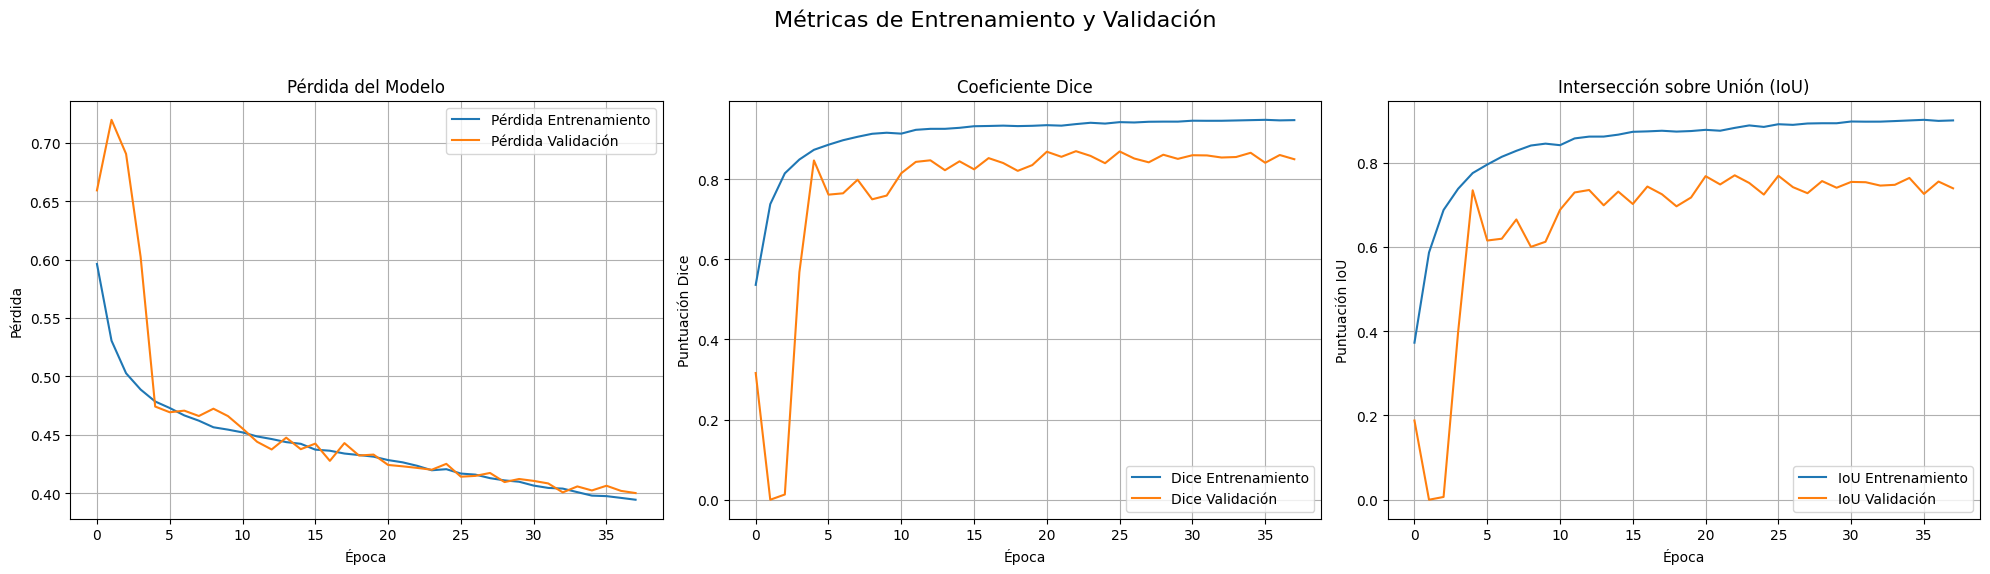

In [12]:
# Graficar historial de entrenamiento
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Métricas de Entrenamiento y Validación', fontsize=16)

# Pérdida
axes[0].plot(train_history['train_loss'], label='Pérdida Entrenamiento')
axes[0].plot(train_history['val_loss'], label='Pérdida Validación')
axes[0].set_title('Pérdida del Modelo')
axes[0].set_xlabel('Época'); axes[0].set_ylabel('Pérdida'); axes[0].legend(); axes[0].grid(True)

# Coeficiente Dice
axes[1].plot(train_history['train_dice'], label='Dice Entrenamiento')
axes[1].plot(train_history['val_dice'], label='Dice Validación')
axes[1].set_title('Coeficiente Dice')
axes[1].set_xlabel('Época'); axes[1].set_ylabel('Puntuación Dice'); axes[1].legend(); axes[1].grid(True)

# IoU
axes[2].plot(train_history['train_iou'], label='IoU Entrenamiento')
axes[2].plot(train_history['val_iou'], label='IoU Validación')
axes[2].set_title('Intersección sobre Unión (IoU)')
axes[2].set_xlabel('Época'); axes[2].set_ylabel('Puntuación IoU'); axes[2].legend(); axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visualizando predicciones del modelo en datos de validación (con post-procesamiento)...


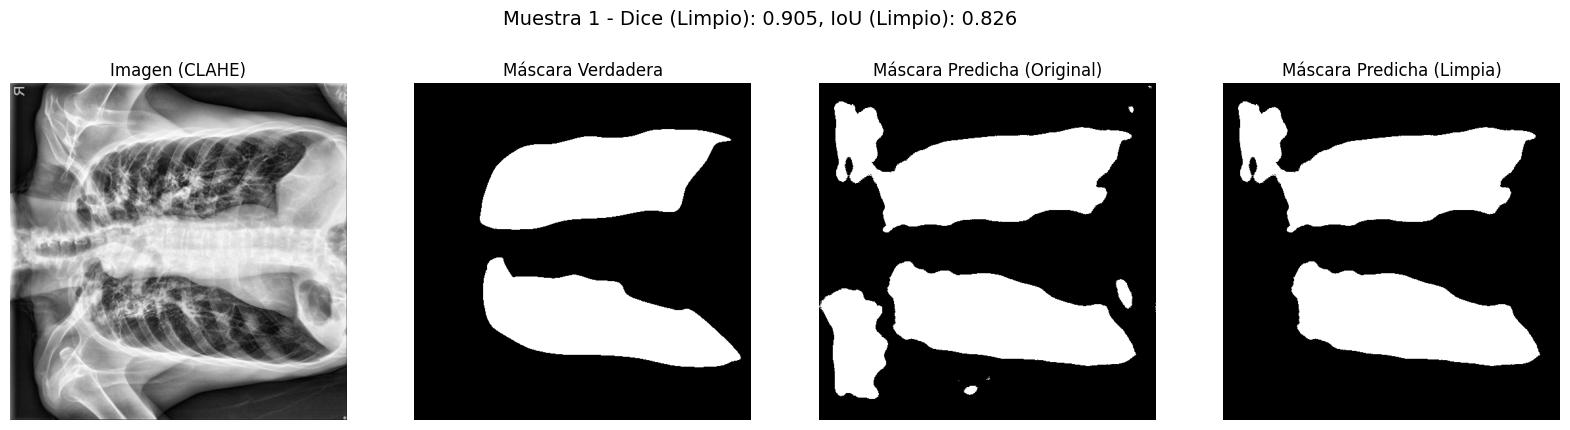

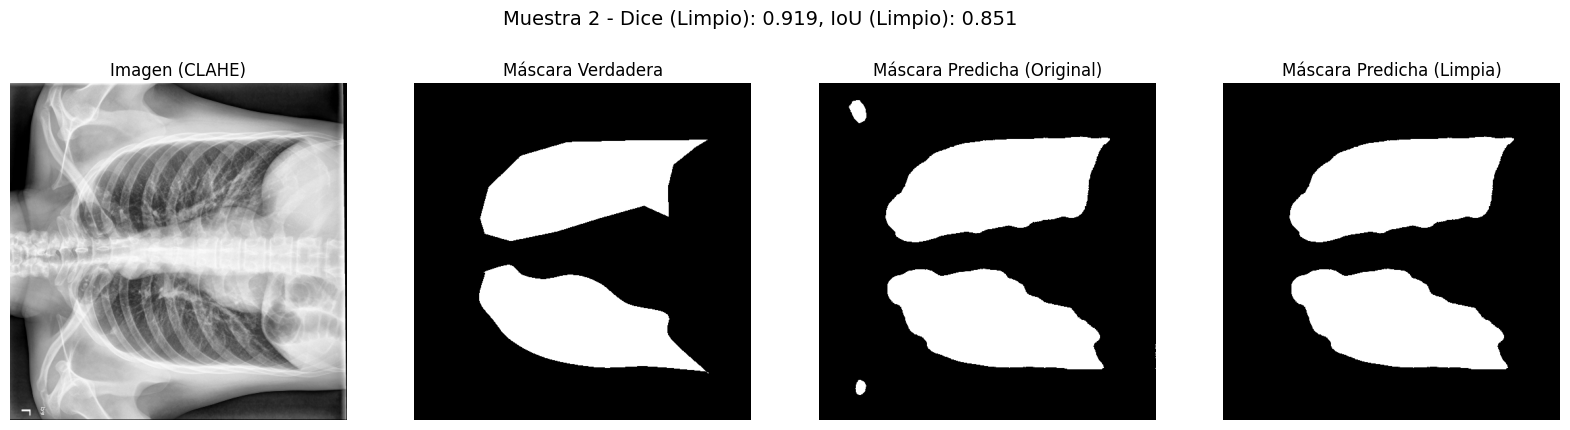

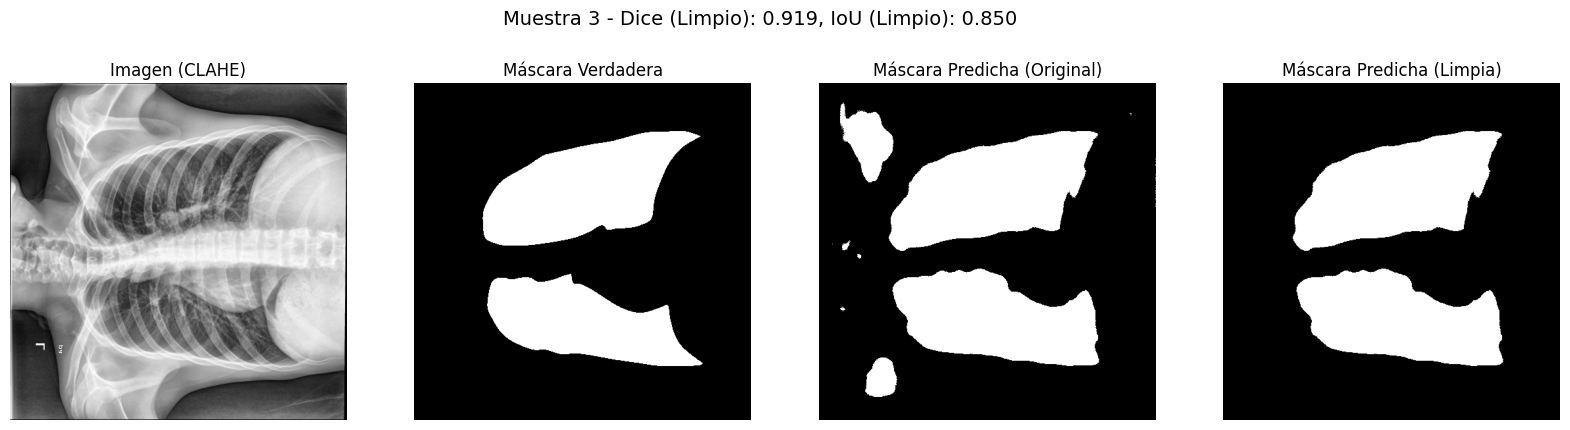

In [20]:
# Función de post-procesamiento usando componentes conectados
def limpiar_mascara_componentes(pred_mask):
    """
    Limpia una máscara de segmentación manteniendo solo los N componentes más grandes.
    Args:
        pred_mask (np.array): Máscara binaria (0s y 1s) de una sola imagen.
    Returns:
        np.array: Máscara limpia.
    """
    # Asegurarse de que la máscara sea de tipo uint8
    mask_uint8 = (pred_mask * 255).astype(np.uint8)

    # Encontrar componentes conectados
    # num_labels: número total de etiquetas (incluyendo el fondo)
    # labels: una imagen donde cada componente tiene un ID único
    # stats: información de cada componente (área, bounding box, etc.)
    # centroids: centroides de cada componente
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    # Si solo hay fondo (num_labels <= 1), devolver una máscara vacía
    if num_labels <= 1:
        return np.zeros_like(pred_mask)

    # El fondo es la etiqueta 0, lo ignoramos calculando el área de las etiquetas 1 en adelante
    areas = stats[1:, cv2.CC_STAT_AREA]

    # Crear una máscara vacía para dibujar los componentes limpios
    cleaned_mask = np.zeros_like(pred_mask, dtype=np.uint8)

    # Mantener los dos componentes más grandes (los pulmones)
    # Obtener los índices de las dos áreas más grandes (excluyendo el fondo)
    # argsort devuelve los índices que ordenarían el array, [::-1] los invierte para obtener de mayor a menor
    #[:2] toma los 2 índices de las áreas más grandes
    top_2_indices = np.argsort(areas)[::-1][:2]

    # Las etiquetas corresponden a los índices + 1 porque ignoramos el fondo (etiqueta 0)
    top_2_labels = top_2_indices + 1

    # Dibujar solo los componentes correspondientes a las 2 etiquetas más grandes
    for label in top_2_labels:
        # Crear una máscara binaria para este componente específico
        component_mask = (labels == label).astype(np.uint8)
        # Sumar este componente a la máscara limpia
        cleaned_mask += component_mask

    # Asegurarse de que la máscara final sea binaria (0 o 1)
    cleaned_mask = (cleaned_mask > 0).astype(np.float32) # Convert back to float32 for consistency

    return cleaned_mask


# Cargar el mejor modelo guardado
model.load_state_dict(torch.load('best_unet_model.pth', map_location=device))
model.eval()

def visualize_predictions(model, loader, device, num_samples=5):
    print("Visualizando predicciones del modelo en datos de validación (con post-procesamiento)...")
    model.eval()

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            if i >= num_samples:
                break

            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions_raw = torch.sigmoid(outputs) # Probabilities

            # Convertir la predicción a numpy y binarizar para post-procesamiento
            predictions_np = predictions_raw[0].cpu().numpy().squeeze() # Take first image in batch
            binary_prediction_np = (predictions_np > 0.5).astype(np.float32)

            # --- Aplicar post-procesamiento ---
            cleaned_prediction_np = limpiar_mascara_componentes(binary_prediction_np)
            # Convertir la máscara limpia de vuelta a tensor para el cálculo de métricas si es necesario
            # Note: Metrics calculation functions (calculate_dice, calculate_iou) expect tensors
            # Let's calculate metrics on the *cleaned* prediction converted back to tensor
            cleaned_prediction_tensor = torch.from_numpy(cleaned_prediction_np).unsqueeze(0).unsqueeze(0).to(device) # Add batch and channel dims back

            # Convertir máscara verdadera a numpy para visualización
            mask_np = masks[0].cpu().numpy().squeeze()

            # Calcular métricas usando la máscara predicha LIMPIA
            dice_score = calculate_dice(cleaned_prediction_tensor, masks[0].unsqueeze(0).unsqueeze(0)) # Ensure mask has batch and channel dims
            iou_score = calculate_iou(cleaned_prediction_tensor, masks[0].unsqueeze(0).unsqueeze(0)) # Ensure mask has batch and channel dims


            fig, axes = plt.subplots(1, 4, figsize=(20, 5)) # Increased figure size for 4 plots
            fig.suptitle(f'Muestra {i+1} - Dice (Limpio): {dice_score:.3f}, IoU (Limpio): {iou_score:.3f}', fontsize=14)

            axes[0].imshow(images[0].cpu().numpy().squeeze(), cmap='gray'); axes[0].set_title('Imagen (CLAHE)'); axes[0].axis('off')
            axes[1].imshow(mask_np, cmap='gray'); axes[1].set_title('Máscara Verdadera'); axes[1].axis('off')
            axes[2].imshow(binary_prediction_np, cmap='gray'); axes[2].set_title('Máscara Predicha (Original)'); axes[2].axis('off') # Show original prediction
            axes[3].imshow(cleaned_prediction_np, cmap='gray'); axes[3].set_title('Máscara Predicha (Limpia)'); axes[3].axis('off') # Show cleaned prediction


            plt.show()

# Visualizar algunas predicciones (con post-procesamiento)
visualize_predictions(model, val_loader, device, num_samples=3)